In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F          # adds some efficiency
from torch.utils.data import DataLoader  # lets us load data in batches
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix  # for evaluating results
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root="./",download=True, train=True, transform=transform)

In [4]:
test_data = datasets.MNIST(root="./",download=True, train=False, transform=transform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ./
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [7]:
image, label = train_data[0]

In [8]:
image.shape

torch.Size([1, 28, 28])

In [9]:
label

5

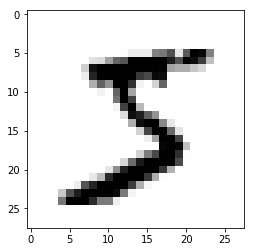

In [12]:
plt.imshow(image.reshape(28, 28), cmap="gist_yarg") # default cmap="viridis"

In [30]:
torch.manual_seed(101) # Random Shuffle
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

In [15]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}')) # to widen the printed array

for images, labels in train_loader:
    break

In [16]:
images.shape

torch.Size([100, 1, 28, 28])

Labels:  [   0    5    7    8    6    7    9    7    1    3    8    4]


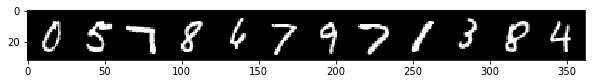

In [17]:
# Print the first 12 labels
print('Labels: ', labels[:12].numpy())

# Print the first 12 images
im = make_grid(images[:12], nrow=12)  # the default nrow is 8
plt.figure(figsize=(10,4))
# We need to transpose the images from CWH to WHC
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [19]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, in_sz=784, out_sz=10, layers=[120, 84]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1], out_sz)
        
    def forward(self, X):
        X = F.relu(self.fc1(X)) # Activation Fn
        X = F.relu(self.fc2(X)) 
        X = self.fc3(X) 
        
        return F.log_softmax(X, dim=1) # Multi-class 

In [20]:
torch.manual_seed(101)
model = MultilayerPerceptron()

In [21]:
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [22]:
# Current "ANN" => Later "CNN"
for param in model.parameters():
    print(param.numel()) # Count how many params
    # 105,214 in total

94080
120
10080
84
840
10


In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
images.view(100, -1) # Means [100, 1, 28, 28] => [100, 784]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [38]:
import time
start_time = time.time()

epochs = 10
# Mainly for visualization
train_losses = []
test_losses = []
train_corrects = []
test_corrects = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # X_train => Images; y_train => Labels
    for b, (X_train, y_train) in enumerate(train_loader):
        b = b + 1
        # 10 Neurons => [0.1, 0.6, 0.2, ...]
        y_pred = model(X_train.view(100, -1))
        loss = criterion(y_pred, y_train)
        
        predicted = torch.max(y_pred, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{100*b:6}/60000]  loss: {loss.item():10.8f} accuracy: {trn_corr.item()*100/(100*b):7.3f}%')

     # Update train loss & accuracy for the epoch
    train_losses.append(loss)
    train_corrects.append(trn_corr)
    
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test.view(500, -1))  # Here we flatten X_test

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
    # Update test loss & accuracy for the epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_corrects.append(tst_corr)

total_time = time.time() - start_time
print(f'Duration: {total_time / 60} mins')

epoch:  0  batch:  200 [ 20000/60000]  loss: 0.01074876 accuracy:  99.640%
epoch:  0  batch:  400 [ 40000/60000]  loss: 0.00258396 accuracy:  99.627%
epoch:  0  batch:  600 [ 60000/60000]  loss: 0.03405758 accuracy:  99.525%
epoch:  1  batch:  200 [ 20000/60000]  loss: 0.00734695 accuracy:  99.625%
epoch:  1  batch:  400 [ 40000/60000]  loss: 0.00500208 accuracy:  99.515%
epoch:  1  batch:  600 [ 60000/60000]  loss: 0.01757078 accuracy:  99.472%
epoch:  2  batch:  200 [ 20000/60000]  loss: 0.00364725 accuracy:  99.635%
epoch:  2  batch:  400 [ 40000/60000]  loss: 0.01025984 accuracy:  99.642%
epoch:  2  batch:  600 [ 60000/60000]  loss: 0.01754833 accuracy:  99.630%
epoch:  3  batch:  200 [ 20000/60000]  loss: 0.01980995 accuracy:  99.620%
epoch:  3  batch:  400 [ 40000/60000]  loss: 0.02789734 accuracy:  99.585%
epoch:  3  batch:  600 [ 60000/60000]  loss: 0.01464937 accuracy:  99.568%
epoch:  4  batch:  200 [ 20000/60000]  loss: 0.00082234 accuracy:  99.825%
epoch:  4  batch:  400 [ 

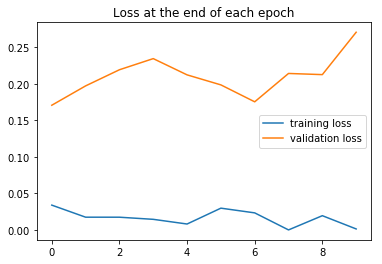

In [39]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

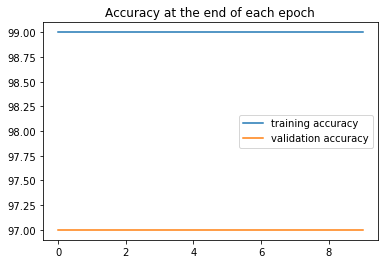

In [40]:
plt.plot([t/600 for t in train_corrects], label='training accuracy')
plt.plot([t/100 for t in test_corrects], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [41]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [42]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))  # pass in a flattened view of X_test
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9744/10000 =  97.440%


In [43]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 970    0    3    0    0    1    2    1    4    0]
 [   1 1126    3    0    1    0    2    7    2    2]
 [   1    3 1005    5    2    0    0   10    2    1]
 [   1    1    6  973    1    3    1    1    2    4]
 [   0    0    2    0  939    2    0    5    3   11]
 [   1    0    1   17    2  878    6    2   11   10]
 [   3    3    6    1   26    5  947    0    6    2]
 [   2    0    2    2    2    1    0  996    3    2]
 [   1    2    4    5    1    1    0    2  937    4]
 [   0    0    0    7    8    1    0    4    4  973]]
